In [13]:
import numpy as np
import tensorflow as tf

In [4]:
num_samples_per_class = 1000

# ←---- (本行及以下3行)生成第一个类别的点：1000个二维随机点。协方差矩阵为[[1, 0.5], [0.5, 1]]，对应于一个从左下方到右上方的椭圆形点云
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
negative_samples

array([[ 0.14859027,  1.59443585],
       [-0.37086459,  4.00232551],
       [ 0.39735672,  3.67775578],
       ...,
       [ 1.4690683 ,  3.97679239],
       [-0.75902327,  3.00014022],
       [ 0.45508588,  2.63205688]])

In [6]:
#  ←---- (本行及以下3行)生成第二个类别的点，协方差矩阵相同，均值不同
positive_samples = np.random.multivariate_normal( 
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class)
positive_samples

array([[ 2.60274559, -0.1935772 ],
       [ 3.06496431,  1.20552382],
       [ 2.01892683,  0.17001649],
       ...,
       [ 3.16747906, -0.08768664],
       [ 2.16218314, -1.45585843],
       [ 3.97964899,  0.58139749]])

In [9]:
#堆叠两个协方差矩阵
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
len(inputs)

2000

In [11]:
#生成对应的目标标签
targets = np.vstack((np.zeros((num_samples_per_class, 1), dtype="float32"),
                     np.ones((num_samples_per_class, 1), dtype="float32")))

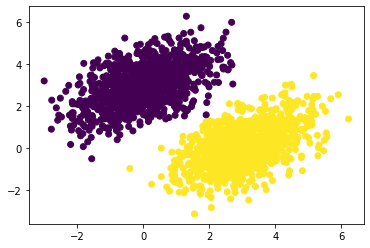

In [12]:
import matplotlib.pyplot as plt
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

In [14]:
#使用线性分类器采用仿射变换（prediction = W•input + b），我们对其进行训练，使预测值与目标值之差的平方最小化。
W=tf.Variable(initial_value=tf.random.uniform(shape=(2,1)))
W

<tf.Variable 'Variable:0' shape=(2, 1) dtype=float32, numpy=
array([[0.6170759],
       [0.7531054]], dtype=float32)>

In [15]:
b=tf.Variable(initial_value=tf.zeros(shape=(2,)))
b

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>

In [18]:
#向前传播因为这个线性分类器处理的是二维输入，所以W实际上只包含两个标量系数W1和W2：W = [[w1],[w2]]。b则是一个标量系数。
#对于给定的输入点[x, y]，其预测值为：prediction =[[w1], [w2]]•[x, y] + b = w1 * x + w2 * y + b
def model(inputs):
    return tf.matmul(inputs, W) + b

In [19]:
#均方误差损失函数
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions) #  ←---- per_sample_losses是一个与targets和predictions具有相同形状的张量，其中包含每个样本的损失值
    return tf.reduce_mean(per_sample_losses)  #←----我们需要将每个样本的损失值平均为一个标量损失值，这由reduce_mean来实现

In [20]:
#训练步骤
learning_rate = 0.1  #学习率

def training_step(inputs, targets):
    with tf.GradientTape() as tape: # ←---- (本行及以下2行)在一个梯度带作用域内进行一次前向传播
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b]) # ←----检索损失相对于权重的梯度
    W.assign_sub(grad_loss_wrt_W * learning_rate)  #←---- (本行及以下1行)更新权重
    b.assign_sub(grad_loss_wrt_b * learning_rate)
    return loss

In [21]:
#批量训练，在所有数据上进行训练（计算梯度并更新权重）
for step in range(40):
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 4.3295
Loss at step 1: 0.4279
Loss at step 2: 0.1418
Loss at step 3: 0.1136
Loss at step 4: 0.1076
Loss at step 5: 0.1035
Loss at step 6: 0.0999
Loss at step 7: 0.0964
Loss at step 8: 0.0930
Loss at step 9: 0.0898
Loss at step 10: 0.0868
Loss at step 11: 0.0839
Loss at step 12: 0.0811
Loss at step 13: 0.0785
Loss at step 14: 0.0760
Loss at step 15: 0.0736
Loss at step 16: 0.0713
Loss at step 17: 0.0691
Loss at step 18: 0.0670
Loss at step 19: 0.0650
Loss at step 20: 0.0632
Loss at step 21: 0.0614
Loss at step 22: 0.0596
Loss at step 23: 0.0580
Loss at step 24: 0.0564
Loss at step 25: 0.0549
Loss at step 26: 0.0535
Loss at step 27: 0.0522
Loss at step 28: 0.0509
Loss at step 29: 0.0496
Loss at step 30: 0.0485
Loss at step 31: 0.0473
Loss at step 32: 0.0463
Loss at step 33: 0.0452
Loss at step 34: 0.0443
Loss at step 35: 0.0433
Loss at step 36: 0.0424
Loss at step 37: 0.0416
Loss at step 38: 0.0408
Loss at step 39: 0.0400


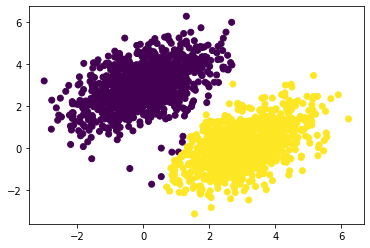

In [44]:
#经过40次迭代之后，训练损失值似乎稳定在0.025左右，给定输入点的预测值小于0.5，那么它将被归为类别0，而如果预测值大于0.5，则被归为类别1
predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()